In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

In [2]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
import pretrainedmodels

In [4]:
train_df = pd.read_csv("./whale-categorization-playground/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [5]:
print(f"There are {len(os.listdir('./whale-categorization-playground/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('./whale-categorization-playground/test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


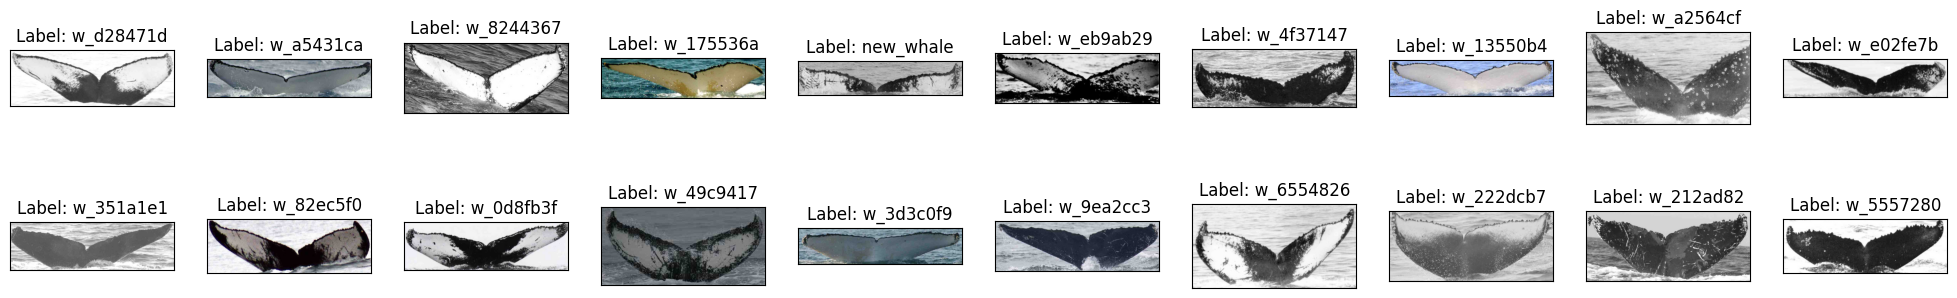

In [6]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("./whale-categorization-playground/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./whale-categorization-playground/train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [7]:
train_df.Id.value_counts().head()

Id
new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: count, dtype: int64

In [8]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

data_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=18, p=0.5),
    A.Affine(shear=0.4, p=0.5), 
    
    A.ToGray(p=0.4),

    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=1.0),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, p=1.0)
    ], p=0.5),

    A.OneOf([
        A.PiecewiseAffine(scale=(0.01, 0.03), p=1.0),
        A.Perspective(p=1.0),
    ], p=0.5),

    A.HorizontalFlip(p=0.5),
    
    ToTensorV2(),
])

C:\Users\user\anaconda3\envs\1019\Lib\site-packages\albumentations\augmentations\blur\transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [10]:
data_transforms_test = A.Compose([
    A.Resize(384, 384),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [11]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [12]:
y, le = prepare_labels(train_df['Id'])

C:\Users\user\anaconda3\envs\1019\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.df = df
        self.transform = transform
        self.image_files_list = [s for s in os.listdir(datafolder)]

        if datatype == 'train':
            self.id_dict = df.groupby('Id').groups

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        if self.datatype == 'train': 
            
            anchor_img_name = os.path.join(self.datafolder, self.df.iloc[idx]['Image'])
            anchor_img = Image.open(anchor_img_name).convert('RGB')
            anchor_img = np.array(anchor_img)

            id = self.df.iloc[idx]['Id']
            positive_list = self.df[self.df['Id'] == id]['Image'].tolist()
            positive_img_name = os.path.join(self.datafolder, random.choice(positive_list))
            positive_img = Image.open(positive_img_name).convert('RGB')
            positive_img = np.array(positive_img)

            negative_id = random.choice(self.df[self.df['Id'] != id]['Id'].unique())
            negative_list = self.df[self.df['Id'] == negative_id]['Image'].tolist()
            negative_img_name = os.path.join(self.datafolder, random.choice(negative_list))
            negative_img = Image.open(negative_img_name).convert('RGB')
            negative_img = np.array(negative_img)

            if self.transform:
                anchor_img = self.transform(image=anchor_img)['image']
                positive_img = self.transform(image=positive_img)['image']
                negative_img = self.transform(image=negative_img)['image']

            return anchor_img, positive_img, negative_img
        else:
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            image = Image.open(img_name).convert('RGB')
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)['image']
            return image

In [14]:
train_dataset = WhaleDataset(datafolder='./whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms)
test_set = WhaleDataset(datafolder='./whale-categorization-playground/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whale-categorization-playground/train/')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('./whale-categorization-playground/test/')))))

batch_size = 16
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_negative = F.pairwise_distance(anchor, negative, p=2)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import lr_scheduler
import torch.optim as optim

class SiameseNetworkWithPretrained(nn.Module):
    def __init__(self):
        super(SiameseNetworkWithPretrained, self).__init__()
        self.backbone = models.resnet50(pretrained=False)
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        output1 = self.backbone(input1).flatten(1)
        output2 = self.backbone(input2).flatten(1)
        distance = torch.abs(output1 - output2)
        output = self.fc(distance)
        return output
    
    def get_embedding(self, x):
        embedding = self.backbone(x).flatten(1)
        return embedding

model = SiameseNetworkWithPretrained()

state_dict = torch.load('best_model.pt')

backbone_state_dict = {k.replace('backbone.', ''): v for k, v in state_dict.items() if k.startswith('backbone.')}

model.backbone.load_state_dict(backbone_state_dict, strict=False)

criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

C:\Users\user\anaconda3\envs\1019\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\1019\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
from tqdm import tqdm
import random

best_loss = 3

# 학습 루프
n_epochs = 30
for epoch in range(n_epochs):
    model.cuda()
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{n_epochs}")
    for i, batch in progress_bar:
        anchor, positive, negative = batch
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        optimizer.zero_grad()
        
        anchor_embedding = model.get_embedding(anchor)
        positive_embedding = model.get_embedding(positive)
        negative_embedding = model.get_embedding(negative)

        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    scheduler.step()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss}")
    
    torch.save(model.state_dict(), 'base_siamese_best_resnet50.pt')

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_siamese_best_resnet50.pt')
        print("Saved best model with loss:", best_loss)

Epoch 1/30: 100%|██████████| 616/616 [17:13<00:00,  1.68s/it, loss=0.122] 


Epoch 1/30, Average Loss: 1.7591584232913984
Saved best model with loss: 1.7591584232913984


Epoch 2/30: 100%|██████████| 616/616 [18:13<00:00,  1.78s/it, loss=2.23]   


Epoch 2/30, Average Loss: 1.0680113523206733
Saved best model with loss: 1.0680113523206733


Epoch 3/30: 100%|██████████| 616/616 [18:50<00:00,  1.83s/it, loss=1]      


Epoch 3/30, Average Loss: 0.944777436808429
Saved best model with loss: 0.944777436808429


Epoch 4/30: 100%|██████████| 616/616 [17:21<00:00,  1.69s/it, loss=1.49]  


Epoch 4/30, Average Loss: 0.8885442281214447
Saved best model with loss: 0.8885442281214447


Epoch 5/30: 100%|██████████| 616/616 [17:59<00:00,  1.75s/it, loss=1.14]  


Epoch 5/30, Average Loss: 0.9443894176889066


Epoch 6/30: 100%|██████████| 616/616 [11:46<00:00,  1.15s/it, loss=1.18]  


Epoch 6/30, Average Loss: 0.9352365453763829


Epoch 7/30: 100%|██████████| 616/616 [11:24<00:00,  1.11s/it, loss=0.568]  


Epoch 7/30, Average Loss: 0.8269016060784653
Saved best model with loss: 0.8269016060784653


Epoch 8/30: 100%|██████████| 616/616 [13:32<00:00,  1.32s/it, loss=0.658]   


Epoch 8/30, Average Loss: 0.8866995314511096


Epoch 9/30:  52%|█████▏    | 321/616 [10:51<09:59,  2.03s/it, loss=0.976] 


KeyboardInterrupt: 

## INFERENCE

In [19]:
class InferenceDataset(Dataset):
    def __init__(self, datafolder, transform=None):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = np.array(Image.open(img_name).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, self.image_files_list[idx]

In [20]:
train_dataset_ = InferenceDataset('./whale-categorization-playground/train', transform=data_transforms)
train_loader_ = DataLoader(train_dataset_, batch_size=32, shuffle=False)
test_dataset_ = InferenceDataset('./whale-categorization-playground/test', transform=data_transforms)
test_loader_ = DataLoader(test_dataset_, batch_size=32, shuffle=False)

In [21]:
from tqdm import tqdm

model = SiameseNetworkWithPretrained()

trained_weights = torch.load('base_siamese_best_resnet50.pt')

model.load_state_dict(trained_weights)

model.cuda()

def extract_embeddings(data_loader, model):
    model.eval()
    embeddings = []
    filenames = []
    with torch.no_grad():
        for data, file in tqdm(data_loader, desc="Extracting embeddings"):
            data = data.cuda()
            embedding = model.get_embedding(data)
            embeddings.append(embedding.cpu())
            filenames.extend(file)
    return torch.cat(embeddings).numpy(), filenames

train_embeddings, train_filenames = extract_embeddings(train_loader_, model)
test_embeddings, test_filenames = extract_embeddings(test_loader_, model)

Extracting embeddings: 100%|██████████| 488/488 [10:19<00:00,  1.27s/it]


In [22]:
from sklearn.neighbors import NearestNeighbors

In [24]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_embeddings)

distances_test, neighbors_test = neigh.kneighbors(test_embeddings)

preds_str = []

threshold = 0.1

for i, test_filename in enumerate(test_filenames):
    sample_result = []
    sample_classes = []

    for d, n in zip(distances_test[i], neighbors_test[i]):
        train_filename = train_filenames[n]
        sample_classes.append(train_filename)
        sample_result.append((train_filename, d))

    if "new_whale" not in sample_classes and distances_test[i][0] > threshold:
        sample_result.append(("new_whale", threshold))

    sample_result.sort(key=lambda x: x[1])
    sample_result = sample_result[:5]
    preds_str.append(" ".join([x[0] for x in sample_result]))

sub = pd.read_csv('./whale-categorization-playground/sample_submission.csv')
sub['Id'] = preds_str
sub.to_csv('./submission/1205.csv', index=False)